# Docker CPU usage simulation notebook

This notebook allow easy configuration of docker containers for simulation and visualising CPU performance metrics.

## Limit the total or relative amount of CPU time share
--cpu-shares : this is the relative weight of each container

--cpu-period : CFS Period (Defaults to 1 second/100000 microseconds)

--cpu-quota : CFS Quota (sets a limit to the amount of CPU time in microseconds a container can use)

## Limit which CPU a container can use
--cpuset-cpus : CPU affinity (e.g. use only CPU 0,3)


### Install Prerequisites - docker

In [ ]:
!/Users/jayc/anaconda/bin/pip install docker

## Configuration options

delay : This is the amount of time to wait before launching the container

### Stress Image Options
args: arguments to pass to the stress container. see https://people.seas.harvard.edu/~apw/stress/


### Docker Options
from https://docs.docker.com/engine/admin/resource_constraints/#cpu

--cpu-shares

Set this flag to a value greater or less than the default of 1024 to increase or reduce the container’s weight, and give it access to a greater or lesser proportion of the host machine’s CPU cycles. This is only enforced when CPU cycles are constrained. When plenty of CPU cycles are available, all containers use as much CPU as they need. In that way, this is a soft limit. --cpu-shares does not prevent containers from being scheduled in swarm mode. It prioritizes container CPU resources for the available CPU cycles. It does not guarantee or reserve any specific CPU access.


#### NOT IMPLEMENTED ( WIP)
--cpuset-cpus

Limit the specific CPUs or cores a container can use. A comma-separated list or hyphen-separated range of CPUs a container can use, if you have more than one CPU. The first CPU is numbered 0. A valid value might be 0-3 (to use the first, second, third, and fourth CPU) or 1,3 (to use the second and fourth CPU).

--cpus

Specify how much of the available CPU resources a container can use. For instance, if the host machine has two CPUs and you set --cpus="1.5", the container will be guaranteed to be able to access at most one and a half of the CPUs. This is the equivalent of setting --cpu-period="100000" and --cpu-quota="150000". Available in Docker 1.13 and higher.


--cpu-period

Specify the CPU CFS scheduler period, which is used alongside --cpu-quota. Defaults to 1 second, expressed in micro-seconds. Most users do not change this from the default. If you use Docker 1.13 or higher, use --cpus instead.

--cpu-quota

Impose a CPU CFS quota on the container. The number of microseconds per --cpu-period that the container is guaranteed CPU access. In other words, cpu-quota / cpu-period. If you use Docker 1.13 or higher, use --cpus instead.

### Further Reading

CFS Scheduler : http://www.linuxjournal.com/magazine/completely-fair-scheduler


### Test setup - Modify the containers list to add/remove containers with various options

In [55]:
from collections import namedtuple

Container = namedtuple('Container', 'name image args cpushare delay cpuset cpuperiod cpuquota')

containers = [
    Container(
        name='c1',
        image='stress',
        args='--cpu 4 --timeout 60',
        cpushare=1024,
        delay=1,
        cpuset=None,
        cpuperiod=None,
        cpuquota=None
    ),
    Container(
        name='c2',
        image='stress',
        args='--cpu 4 --timeout 60',
        cpushare=1024,
        delay=5,
        cpuset=None,
        cpuperiod=None,
        cpuquota=None
    ),
    Container(
        name='c3',
        image='stress',
        args='--cpu 4 --timeout 60',
        cpushare=4096,
        delay=20,
        cpuset=None,
        cpuperiod=None,
        cpuquota=None
    ),
]

### Run the test

In [56]:
import time
import datetime
from  multiprocessing import Pool, Lock
from pprint import pprint
import docker

lock = Lock()

def worker(container):
    if container.delay > 0:
        print("%s : Sleeping %d seconds" % (container.name, container.delay))
        time.sleep(container.delay)
    with lock: # the docker client is not thread safe as I've hit some weird behaviour without the lock
        client = docker.from_env()

        print("Launching container %s" % container.name)
        run = client.containers.run(container.image,
                                    container.args,
                                    detach=True,
                                    cpu_shares=container.cpushare)
        
    res = [] # Result list which contains Graphite-like tuples of (datetime, name, value)
    stat = run.stats(decode=True) # This returns a docker stat generator 
    initial = True
    previous_cpu = 0
    previous_system = 0
    for s in stat:      
        if initial:
            previous_cpu = s['cpu_stats']['cpu_usage']['total_usage']
            previous_cystem = s['cpu_stats']['system_cpu_usage']
            initial = False
            continue
        #if not run.attrs['State']['Running']: # BUG ? this is always false even when running
        #    break
        if s['cpu_stats']['cpu_usage']['total_usage'] == 0: # This is an indicator our container has stopped running
            break
        
        # See https://stackoverflow.com/questions/30271942/get-docker-container-cpu-usage-as-percentage
        # Basically , the numbers we get are in nanoseconds (Actual CPU time ?)
        cpu_delta = s['cpu_stats']['cpu_usage']['total_usage'] - previous_cpu
        previous_cpu = s['cpu_stats']['cpu_usage']['total_usage']
        system_delta = s['cpu_stats']['system_cpu_usage'] - previous_system
        previous_system = s['cpu_stats']['system_cpu_usage']
        
        if system_delta > 0 and cpu_delta > 0:
            cpu_percent = (float(cpu_delta) / float(system_delta)) * float(len(s['cpu_stats']['cpu_usage']['percpu_usage'])) * 100.0
            res.append((datetime.datetime.now(), container.name, cpu_percent))
        time.sleep(1)
    return res

    
pool = Pool(processes=len(containers))
async_result = pool.map_async(worker, containers)
pool.close()
pool.join()
    
results = async_result.get()

c2 : Sleeping 5 seconds
c3 : Sleeping 20 seconds
c1 : Sleeping 1 seconds
Launching container c1
Launching container c2
Launching container c3


### Convert Results to Pandas Dataframe

In [57]:
import pandas as pd

data = [datapoint for container_result in results for datapoint in container_result] # Flatten the results

df = pd.DataFrame(data, columns=['timestamp', 'container', 'cpu_percent'])
df.index = df.timestamp

# Drop the timestamp column as the index is replaced with timestamp now
df = df.drop(['timestamp'], axis=1)
df.sort_index(inplace=True)

### Plot the results

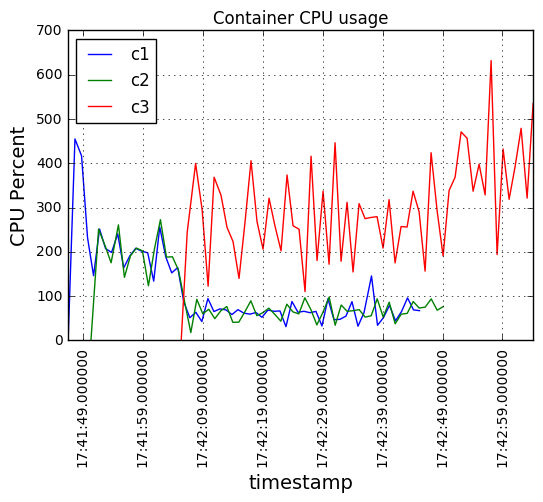

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt


for key, grp in df.groupby('container'):
    plt.plot(grp['cpu_percent'], label=key)

plt.legend(loc='best')
plt.title('Container CPU usage')
plt.xlabel('timestamp', fontsize=14)
plt.xticks(rotation='vertical')
plt.ylabel('CPU Percent', fontsize=14)
plt.grid(True)
plt.show()